In [2]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(ggsci)
  library(scales)
  library(maftools)
  library(Seurat)
  library(reshape2)
  library(viridis)
  library(DESeq2)
  library(clusterProfiler)
  library(enrichplot)
  library(tidyverse)
  library(org.Hs.eg.db)
  library(DOSE)
  library(pathview)
  library(msigdbr)
  library(dplyr)
  library(ggplot2)
  library(pheatmap)
  library(RColorBrewer)
  library(ggrepel)
  library(tidyverse)
})

In [ ]:
mytheme <- ggplot2::theme(
  plot.background = element_blank(),
  panel.background = element_rect(fill = "#FFFFFF"),
  legend.background = element_blank(),
  legend.box.background = element_blank(),
  panel.border = element_rect(linetype = "solid", colour = "black", fill = NA, size = 0.5),
  panel.grid.major = element_blank(), # element_line(colour = "#f0f0f0", linetype = "dashed"),
  panel.grid.minor = element_blank(),
  axis.line = element_blank()
)

color <- c(c(pal_d3("category20")(20), "#B52D73", "#4347B5", "#4FED28", "#402727", "#48959C", "#FC6262", "#4A9EFF", "#9E969E"))
# specify colors
data_color <- c("#197EC0FF", "#ff8000")
tissue_color <- c("#2CA02CFF", "#E377C2FF")
celltype1_color <- c("#0072B5FF", "#D62728FF") # c(pal_nejm("default")(8)[c(2,1)])
celltype2_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF")
celltype3_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF", "#ff7f00", "#ffff33", "#8A9197FF")
celltype4_color <- c("#20854EFF", "#008EA0FF", "#FF6F00FF", "#C71000FF")

patient_color <- c(
  "#FED439FF", "#8A9197FF", "#8A4198FF", "#D5E4A2FF", "#197EC0FF", "#FD7446FF", "#46732EFF", "#71D0F5FF", "#E377C2FF",
  "#075149FF", "#e60000", "#91331FFF", "#1A9993FF", "#ff80aa", "#D2AF81FF", "#370335FF", "#cc99ff", "#ff8000", "#59b300"
)

# Loading WES result

In [5]:
# Reading MAF files
wes_pre <- read.maf(
  maf = "/gpfs1/tangfuchou_pkuhpc/tangfuchou_cls/luping/project/ont_iso_crc/4_EXON_CRC/results/03_04_annovar_CRC_HTCRC/CRC_HTCRC.maf",
  clinicalData = "/gpfs1/tangfuchou_pkuhpc/tangfuchou_cls/luping/project/ont_iso_crc/4_EXON_CRC/results/03_04_annovar_CRC_HTCRC/sample.txt"
)

-Reading
-Validating
-Silent variants: 64081 
-Summarizing
--Possible FLAGS among top ten genes:
  MUC16
-Processing clinical data
-Finished in 6.895s elapsed (7.628s cpu) 


## filtering

In [7]:
wes <- subsetMaf(maf = wes_pre, query = "FILTER %in% 'PASS' & t_depth >= 10 & t_alt_count >= 3 & n_depth >= 10 & n_alt_count <= 1")
dim(wes@data)
# write.table(wes@data, file = "01_WES_filter.maf", row.names = F, sep='\t', quote = F)

--Possible FLAGS among top ten genes:
  TTN
-Processing clinical data


[1] 1580  114

In [9]:
wes@clinical.data$Tumor_Sample_Barcode <- factor(wes@clinical.data$Tumor_Sample_Barcode, levels = c(
  "WES_CRC01_PT1", "WES_CRC01_PT2", "WES_CRC02_PT1", "WES_CRC02_PT2", "WES_CRC03_PT1", "WES_CRC04_PT1", "WES_CRC04_PT2", "WES_CRC05_PT1", "WES_CRC05_PT2",
  "WES_CRC07_PT1", "WES_CRC07_PT2", "WES_CRC08_PT1", "WES_CRC08_PT2", "WES_CRC09_PT1", "WES_CRC09_PT2", "WES_CRC10_PT1",
  "WES_HTCRC01_PT", "WES_HTCRC04_PT", "WES_HTCRC05_PT"
))

In [14]:
saveRDS(wes, file = "01_WES_object.rds")

In [15]:
# Suppl Table
write.table(wes@data[, c(
  "Tumor_Sample_Barcode", "Matched_Norm_Sample_Barcode",
  "Hugo_Symbol", "Chromosome", "Start_Position", "End_Position",
  "Strand", "Variant_Type", "Variant_Classification", "Reference_Allele", "Tumor_Seq_Allele1", "Tumor_Seq_Allele2", "Match_Norm_Seq_Allele1",
  "t_depth", "t_ref_count", "t_alt_count", "n_depth", "n_ref_count", "n_alt_count",
  "dbSNP_RS", "HGVSc", "HGVSp" #' SOMATIC'
)], file = "01_WES_filter.txt", row.names = F, quote = F, sep = "\t")

In [13]:
wes <- readRDS(file = "01_WES_object.rds")

In [14]:
test <- wes@data
test$mutation <- paste0(test$Chromosome, test$Start_Position, test$End_Position)
length(unique(test$mutation))
table(test[!duplicated(test$mutation), ]$Variant_Type)
length(unique(test$Hugo_Symbol))

[1] 1228


DEL DNP INS SNP TNP 
121  13 196 896   2 

[1] 1110

In [17]:
# https://gatk.broadinstitute.org/hc/en-us/articles/360041848811-Funcotator
# variantClassification
# Frame_Shift_Del: Deletion that moves the sequence out of frame. Can occur in Coding regions or Introns.
# Frame_Shift_Ins: Insertion that moves the coding sequence out of frame. Can occur in Coding regions or Introns.
# In_Frame_Del: Deletion that keeps the sequence in frame. Can occur in Coding regions or Introns.
# In_Frame_Ins: Insertion that keeps the sequence in frame. Can occur in Coding regions or Introns.
# Missense_Mutation: The point mutation alters the protein structure by one amino acid. Can occur in Coding regions or Introns.
# Nonsense_Mutation: A premature stop codon is created by the variant. Can occur in Coding regions or Introns.
# Nonstop_Mutation: Variant removes stop codon. Can occur in Coding regions or Introns.
# Splice_Site: The variant is within a configurable number of bases of a splice site. See the secondary classification to determine if it lies on the exon or intron side. Can occur in Coding regions or Introns.
# Translation_Start_Site:

## WES result plot

In [19]:
vc_cols <- c("#2078B4", "#FB9A99", "#B1E08A", "#FEBF6F", "#E3211C", "#A5CEE2", "#32A02A", "#FEE08B", "#A989EA")
names(vc_cols) <- c(
  "Missense_Mutation", "Frame_Shift_Ins", "Nonsense_Mutation", "Splice_Site", "In_Frame_Ins",
  "Frame_Shift_Del", "Multi_Hit", "In_Frame_Del", "Translation_Start_Site"
)

In [20]:
pdf("01_summary.pdf", width = 7, height = 5)
plotmafSummary(maf = wes, rmOutlier = TRUE, addStat = "median", dashboard = TRUE, titvRaw = FALSE, color = vc_cols)
dev.off()

png 
  2

In [21]:
pdf("01_oncoplot.pdf", width = 4.5, height = 7)
oncoplot(
  maf = wes, top = 30, showTumorSampleBarcodes = T, sampleOrder = wes@clinical.data$Tumor_Sample_Barcode,
  colors = vc_cols,
  draw_titv = F # or FALSE
)
dev.off()

png 
  2

In [23]:
wes_titv <- titv(maf = wes, plot = FALSE, useSyn = TRUE)
pdf("01_titv.pdf", width = 4, height = 3.5)
plotTiTv(res = wes_titv)
dev.off()

png 
  2

In [24]:
pdf("01_oncogenicpathway.pdf", width = 6, height = 4)
OncogenicPathways(maf = wes)
dev.off()

Pathway,N,n_affected_genes,fraction_affected,Mutated_samples,Fraction_mutated_samples
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
TGF-Beta,7,1,0.14285714,2,0.1052632
TP53,6,1,0.16666667,15,0.7894737
PI3K,29,3,0.10344828,7,0.3684211
Hippo,38,6,0.15789474,11,0.5789474
RTK-RAS,85,7,0.08235294,11,0.5789474
NOTCH,71,8,0.11267606,8,0.4210526
WNT,68,8,0.11764706,17,0.8947368


png 
  2

# oncogenicpathway

In [25]:
for (mypathway in c("WNT", "Hippo", "NOTCH", "RTK-RAS", "PI3K", "TP53", "TGF-Beta")) {
  pdf(sprintf("02_oncogenicpathway_%s.pdf", mypathway), width = 6, height = 2.4)
  PlotOncogenicPathways(maf = wes, pathways = mypathway, showTumorSampleBarcodes = T)
  dev.off()
}

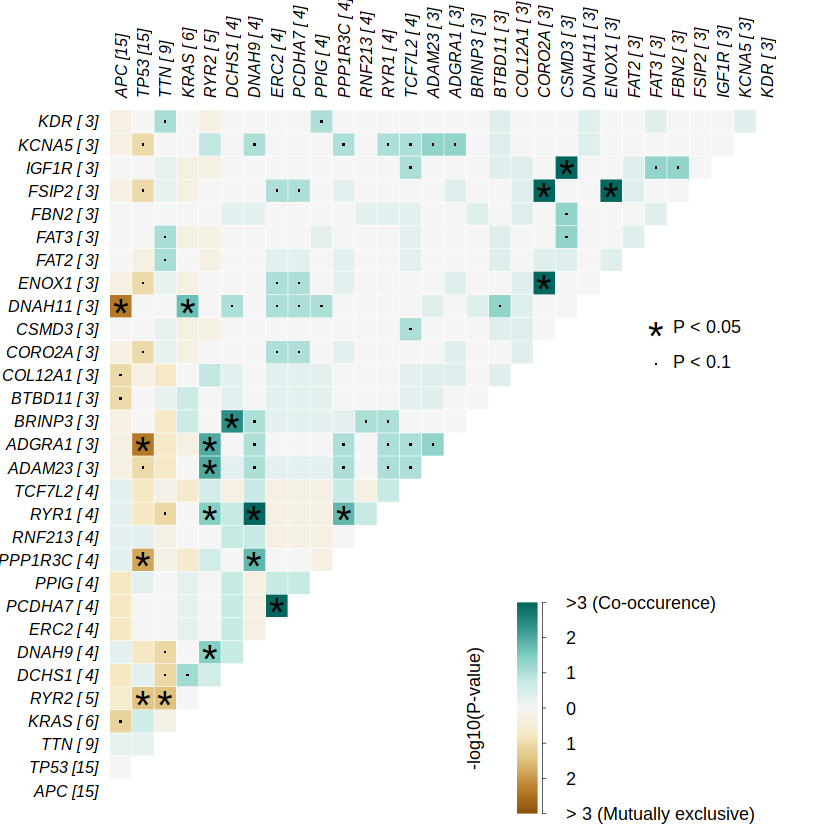

In [26]:
mut_relationship <- somaticInteractions(maf = wes, top = 30, pvalue = c(0.05, 0.1))

In [ ]:
lollipopPlot(maf = wes, gene = c("APC"), AACol = "HGVSp", showMutationRate = TRUE)
lollipopPlot(maf = wes, gene = c("TP53"), AACol = "HGVSp_Short", showMutationRate = TRUE)
#' DDX23''HNRNPH3''PCBP1''PCBP2''PPIG''PTBP2''THOC1'

# RNA SNV form WES

In [24]:
ont <- readRDS(file = "../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
meta <- ont@meta.data
table(meta$patient, meta$celltype1) %>%
  as.data.frame.matrix() %>%
  dplyr::arrange(-`Cancer cells`)

,Normal epithelium,Cancer cells
,<int>,<int>
HTCRC04,213,526
HTCRC05,147,504
HTCRC01,58,413
CRC07,60,216
CRC09,60,145
CRC01,35,131
CRC05,35,130
CRC08,21,111
CRC02,33,89


In [25]:
# 1-based
wes <- readRDS(file = "01_WES_object.rds")
wes_maf <- read.table(file = "01_WES_filter.maf", header = T, sep = "\t")
wes_maf_easy <- data.frame(
  GeneName = wes_maf$Hugo_Symbol,
  chr_pos = paste0(wes_maf$Chromosome, "_", wes_maf$Start_Position),
  Strand = wes_maf$Strand,
  Variant_Classification = wes_maf$Variant_Classification,
  Variant_Type = wes_maf$Variant_Type,
  dbSNP_RS = wes_maf$dbSNP_RS,
  Transcript_ID = wes_maf$Transcript_ID,
  Exon_Number = wes_maf$Exon_Number,
  WES_patient = sapply(strsplit(wes_maf$Tumor_Sample_Barcode, split = "_"), function(x) {
    x[2]
  }),
  Reference_Allele = wes_maf$Reference_Allele,
  Tumor_Seq_Allele1 = wes_maf$Tumor_Seq_Allele1,
  Tumor_Seq_Allele2 = wes_maf$Tumor_Seq_Allele2,
  t_depth = wes_maf$t_depth,
  t_alt_count = wes_maf$t_alt_count,
  t_ref_count = wes_maf$t_ref_count,
  n_depth = wes_maf$n_depth,
  n_ref_count = wes_maf$n_ref_count,
  n_alt_count = wes_maf$n_alt_count,
  HGVSc = wes_maf$HGVSc,
  HGVSp_Short = wes_maf$HGVSp_Short,
  HGVSp = wes_maf$HGVSp,
  Existing_variation = wes_maf$Existing_variation
)
wes_maf_easy$patient_chr_pos <- paste0(wes_maf_easy$WES_patient, "_", wes_maf_easy$chr_pos)
# Due to differences in DEL Variant_Type annotation between MAF and VCF files,
# we subtract 1 from the coordinates of DEL entries in the MAF file to align them
# with RNA_SNV results, which are based on VCF pileup coordinates.
wes_maf_easy[which(wes_maf_easy$Variant_Type %in% "DEL"), ]$chr_pos <- paste0(
  wes_maf[which(wes_maf_easy$Variant_Type %in% "DEL"), ]$Chromosome, "_",
  wes_maf[which(wes_maf_easy$Variant_Type %in% "DEL"), ]$Start_Position - 1
)
wes_maf_easy <- merge(wes_maf_easy, wes@gene.summary[, c("Hugo_Symbol", "MutatedSamples")] %>% dplyr::rename(., GeneName = "Hugo_Symbol"), by = "GeneName", all.x = T)
dim(wes_maf_easy)
wes_maf_easy <- wes_maf_easy[!duplicated(wes_maf_easy), ]
wes_maf_easy$gene_chr_pos <- paste0(wes_maf_easy$GeneName, "_", wes_maf_easy$chr_pos)
dim(wes_maf_easy)
wes_maf_easy$chr_pos <- NULL

[1] 1580   24

[1] 1579   25

In [ ]:
snv <- read.csv(file = "../../0_smk_CRC_HTCRC/results/SNV_bam2matrix_pileup_merge/RNA_SNV_merged_1-based.csv", header = T)
# dim(snv)
snv <- snv %>% mutate(chr_pos = paste0("chr", chrom, "_", pos))
# dim(snv)
snv <- merge(snv, meta[, c("CellName", "patient")], by = "CellName", all.x = T) %>% mutate(patient_chr_pos = paste0(patient, "_", chr_pos))
# dim(snv)
wes_maf_easy_unique <- wes_maf_easy[!duplicated(wes_maf_easy[, c("patient_chr_pos", "gene_chr_pos", "GeneName", "Strand", "Variant_Classification", "WES_patient")]), ]
snv <- merge(snv, wes_maf_easy_unique, by = "patient_chr_pos", all.x = T)
# dim(snv)
# length(unique(snv$GeneName))
snv <- snv %>% filter(patient == WES_patient)
# dim(snv)

## Number of genomic positions covered by RNA-seq data

In [31]:
gene_cts <- read.csv(file = "../CRC_HTCRC_01_RNA_QC/00_gene_counts_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
known_gene_cts <- read.table(file = "../CRC_HTCRC_01_RNA_QC/00_gene_counts_known_ref.txt", header = T, sep = "\t", row.names = 1)

In [32]:
# Count how many mutated genes are expressed in the long-read scRNA-seq data
for (p in names(table(wes_maf_easy_unique$WES_patient))) {
  cells_p <- ont@meta.data[which(ont@meta.data$patient %in% p), ]$CellName
  gene_cts_p <- gene_cts[, cells_p]
  known_gene_cts_p <- known_gene_cts[, cells_p]
  wes_p <- wes_maf_easy_unique %>% filter(WES_patient %in% p)

  gene_p <- intersect(
    c(
      rownames(gene_cts_p[which(rowSums(gene_cts_p > 1) > 1), ]),
      rownames(known_gene_cts_p[which(rowSums(known_gene_cts_p > 1) > 1), ])
    ),
    wes_p$GeneName
  )
  len_p <- length(unique(gene_p))
  df_p <- data.frame(patient = p, rna_expressed = len_p, wes = length(unique(wes_p$GeneName)))
  if (p == "CRC01") {
    p_merge <- df_p
    all_gene_p <- gene_p
  } else {
    p_merge <- rbind(p_merge, df_p)
    all_gene_p <- c(all_gene_p, gene_p)
  }
}

In [58]:
genes_expressed <- intersect(unique(all_gene_p), snv$GeneName)
length(genes_expressed)

[1] 473

In [60]:
# Retain only genes that are expressed
snv <- snv %>% filter(GeneName %in% genes_expressed)
dim(snv)

[1] 14885    41

In [61]:
snv$total_count <- snv$alt_count + snv$ref_count
snv$alt_ratio <- snv$alt_count / snv$total_count
snv$ref_ratio <- snv$ref_count / snv$total_count

In [62]:
# Define whether the alt allele is present at this site in the given cell
snv$alt_binom.p.value <- mapply(
  function(x, n, p) {
    if (x + n == 0) {
      return(1)
    } else {
      return(binom.test(x = x, n = n, p = max(0.05, p), alternative = "greater")$p.value)
    }
  },
  x = snv$alt_count, n = snv$ref_count + snv$alt_count, p = snv$other_count / (snv$total_count + snv$other_count)
)
snv$alt_binom.fdr <- p.adjust(snv$alt_binom.p.value, method = "fdr")

In [63]:
# Check for allelic expression imbalance
snv$aei_binom.p.value <- mapply(
  function(x, n) {
    if (x + n == 0) {
      return(1)
    } else {
      return(binom.test(x = x, n = n, alternative = "greater")$p.value) # two.sided
    }
  },
  x = snv$alt_count, n = snv$ref_count + snv$alt_count
)
snv$aei_binom.fdr <- p.adjust(snv$aei_binom.p.value, method = "fdr")

In [64]:
snv <- snv %>% filter(total_count >= 1, CellName %in% ont@meta.data$CellName) # 有些未经过质控的细胞
dim(snv)
write.table(snv, file = "03_0_CRC_RNA_SNV_corresponding_patient.txt", row.names = F, sep = "\t", quote = F)

[1] 14885    41

## Criteria for defining presence of the mutant allele

In [67]:
# Criteria for defining presence of the mutant allele: alt_binom.fdr < 0.05, ref_count+alt_count >=3
snv_alt <- snv %>% filter(alt_binom.fdr < 0.05, ref_count + alt_count >= 3)
snv_alt <- snv_alt[order(snv_alt$patient), ]
dim(snv_alt)
length(unique(snv_alt$gene_chr_pos))
length(unique(snv_alt$GeneName))

[1] 2738   41

[1] 237

[1] 219

In [68]:
write.table(snv_alt, file = "03_1_CRC_RNA_SNV_corresponding_patient_alt.txt", sep = "\t", quote = F, row.names = F)

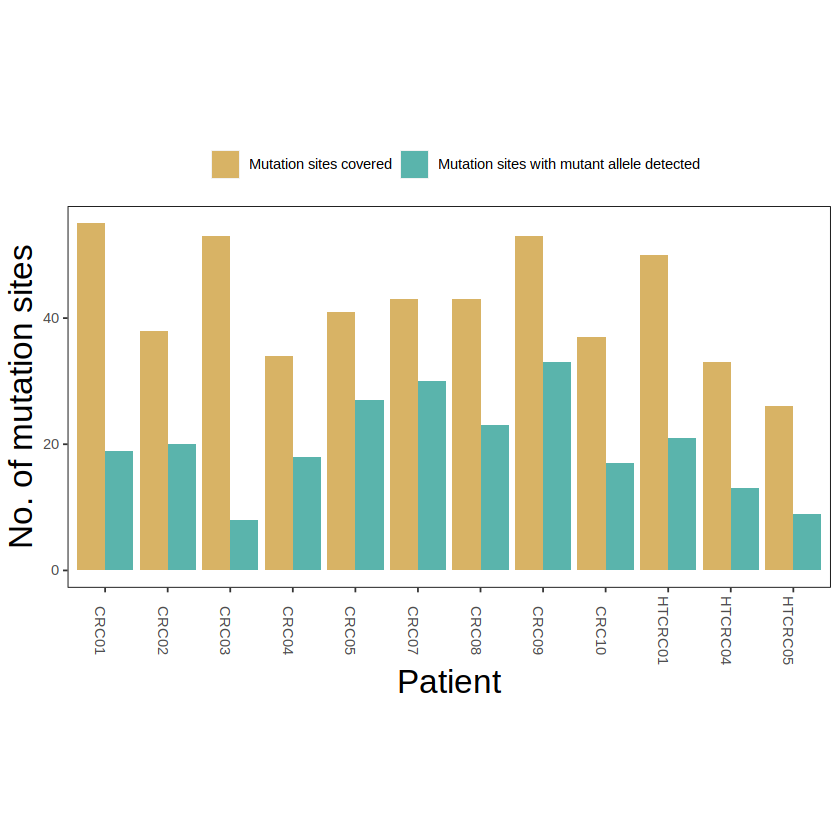

In [124]:
snv_freq <- as.data.frame(table(snv$patient, snv$GeneName)) %>% filter(Freq > 0)
snv_freq <- as.data.frame(table(snv_freq$Var1)) %>%
  filter(Freq > 0) %>%
  dplyr::rename(Patient = Var1)
snv_freq$class <- "Mutation sites covered"

snv_alt_freq <- as.data.frame(table(snv_alt$patient, snv_alt$GeneName)) %>%
  filter(Freq > 0)
snv_alt_freq <- as.data.frame(table(snv_alt_freq$Var1)) %>%
  filter(Freq > 0) %>%
  dplyr::rename(Patient = Var1)
snv_alt_freq$class <- "Mutation sites with mutant allele detected"

freq <- rbind(snv_freq, snv_alt_freq)
freq$class <- factor(freq$class, levels = c(
  #' Genes with mutation sites expressed',
  "Mutation sites covered",
  "Mutation sites with mutant allele detected"
))
ggplot(freq, mapping = aes(x = Patient, y = Freq, fill = class)) +
  geom_bar(width = 0.9, stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("#d8b365", "#5ab4ac", "#6a51a3")) +
  labs(y = "No. of mutation sites") +
  theme(
    legend.position = "top", legend.title = element_blank(), axis.text.x = element_text(angle = 270),
    axis.title = element_text(size = 20), aspect.ratio = 0.5
  ) +
  mytheme
ggsave("03_2_RNA_mutations_freq_with_alt.pdf", height = 4, width = 4)

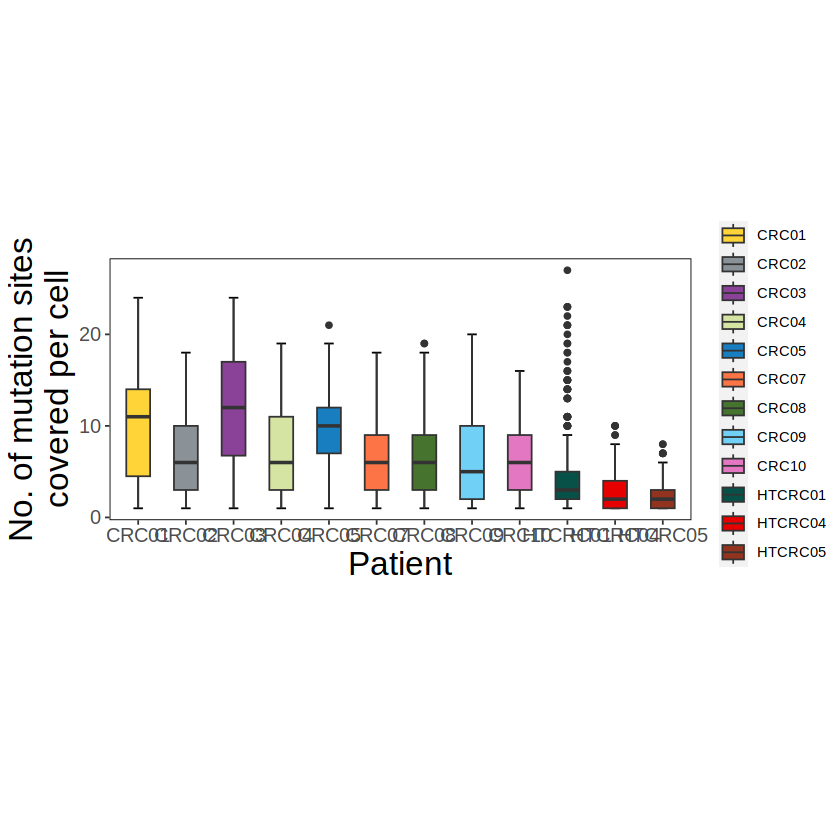

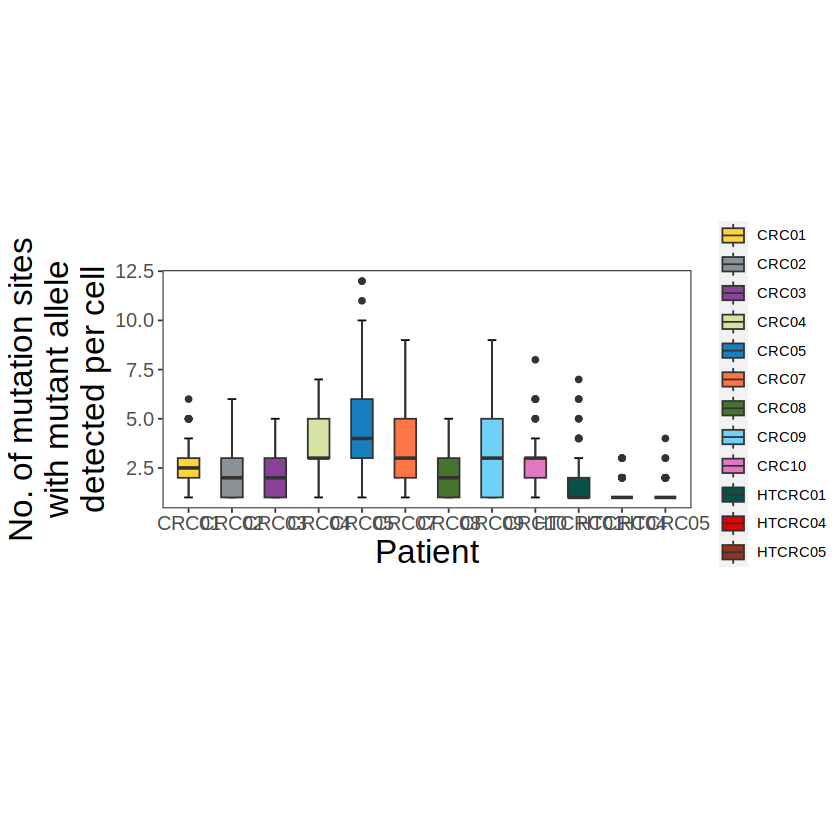

In [73]:
cover_freq <- as.data.frame(table(snv$patient, snv$CellName)) %>% filter(Freq > 0)
ggplot(cover_freq, aes(x = Var1, y = Freq, fill = Var1)) +
  stat_boxplot(geom = "errorbar", linetype = 1, color = "black", position = position_dodge(width = 0.4), width = 0.2) +
  geom_boxplot(width = 0.5) +
  scale_fill_manual(values = patient_color) +
  labs(x = "Patient", y = "No. of mutation sites\ncovered per cell") +
  theme(legend.title = element_blank(), axis.text = element_text(size = 12), axis.title = element_text(size = 20), aspect.ratio = 0.45) +
  mytheme
ggsave("03_2_mutations_freq_per_cell_RNA.pdf", height = 4.2, width = 8)

alt_freq <- as.data.frame(table(snv_alt$patient, snv_alt$CellName)) %>% filter(Freq > 0)
ggplot(alt_freq, aes(x = Var1, y = Freq, fill = Var1)) +
  stat_boxplot(geom = "errorbar", linetype = 1, color = "black", position = position_dodge(width = 0.4), width = 0.2) +
  geom_boxplot(width = 0.5) +
  scale_fill_manual(values = patient_color) +
  labs(x = "Patient", y = "No. of mutation sites\nwith mutant allele\ndetected per cell") +
  theme(legend.title = element_blank(), axis.text = element_text(size = 12), axis.title = element_text(size = 20), aspect.ratio = 0.45) +
  mytheme
ggsave("03_2_mutations_freq_per_cell_RNA_with_alt.pdf", height = 4.2, width = 8)

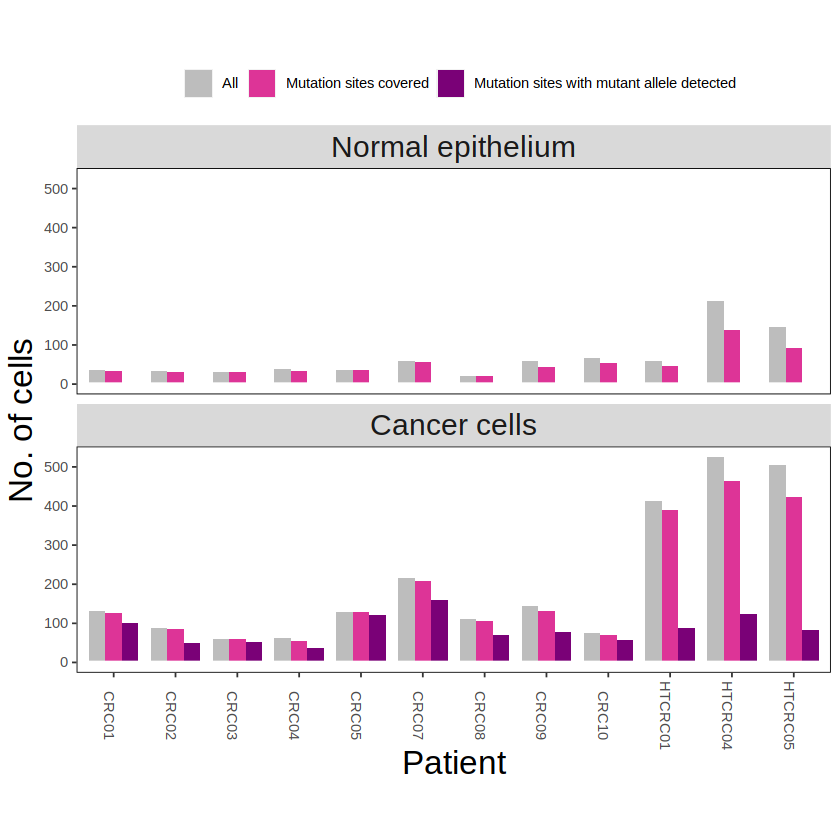

In [125]:
meta_freq <- as.data.frame(table(meta$patient, meta$celltype1))
meta_freq$Data <- "All"

snv_freq <- as.data.frame(table(snv$patient, snv$CellName)) %>%
  filter(Freq > 0) %>%
  dplyr::rename(CellName = Var2, Patient = Var1)
snv_freq <- merge(snv_freq, meta[, c("CellName", "celltype1")], by = "CellName", all.x = T)
snv_freq <- as.data.frame(table(snv_freq$Patient, snv_freq$celltype1))
snv_freq$Data <- "Mutation sites covered"

anv_alt_freq <- as.data.frame(table(snv_alt$patient, snv_alt$CellName)) %>%
  filter(Freq > 0) %>%
  dplyr::rename(CellName = Var2, Patient = Var1)
anv_alt_freq <- merge(anv_alt_freq, meta[, c("CellName", "celltype1")], by = "CellName", all.x = T)
anv_alt_freq <- as.data.frame(table(anv_alt_freq$Patient, anv_alt_freq$celltype1))
anv_alt_freq$Data <- "Mutation sites with mutant allele detected"

freq <- rbind(meta_freq, snv_freq, anv_alt_freq)
freq$Data <- factor(freq$Data, levels = c("All", "Mutation sites covered", "Mutation sites with mutant allele detected"))
ggplot(freq, aes(x = Var1, y = Freq, fill = Data)) +
  geom_bar(position = "dodge", stat = "identity", width = 0.8) +
  geom_hline(yintercept = 0, color = "white", linewidth = 1) +
  mytheme +
  facet_wrap(~Var2, ncol = 1) +
  labs(x = "Patient", y = "No. of cells") +
  scale_fill_manual(values = c("#bdbdbd", "#dd3497", "#7a0177")) +
  theme(
    legend.position = "top", legend.title = element_blank(), axis.text.x = element_text(angle = 270),
    axis.title = element_text(size = 20), aspect.ratio = 0.3, strip.text = element_text(size = 18)
  ) +
  mytheme
ggsave("03_2_mutations_RNA_mut_and_total_cells_with_alt.pdf", height = 8, width = 4)

In [ ]:
test <- snv %>%
  group_by(chr_pos) %>%
  mutate(ncell = length(CellName)) %>%
  filter(alt_binom.fdr < 0.05, ref_count + alt_count >= 3)
dim(test)
test <- test %>% filter(ncell >= 3, t_depth >= 30, t_alt_count / t_depth > 8 / 100)
dim(test)

test <- test %>%
  filter(
    CellName %in% ont@meta.data[which(ont@meta.data$celltype1 %in% "Cancer cells"), ]$CellName,
    WES_patient == patient
  ) %>%
  group_by(
    GeneName, chr_pos, WES_patient, Variant_Classification, Reference_Allele,
    Tumor_Seq_Allele1, Tumor_Seq_Allele2, dbSNP_RS, HGVSc, HGVSp_Short, HGVSp, Existing_variation
  ) %>%
  summarise(
    ref = sum(ref_count), alt = sum(alt_count),
    ratio = sum(alt_count + other_count) / sum(ref_count + other_count)
  ) %>%
  filter(ref + alt >= 30) %>%
  arrange(-ratio) %>%
  filter(is.finite(ratio), ratio > 0)
test$order <- c(1:nrow(test))

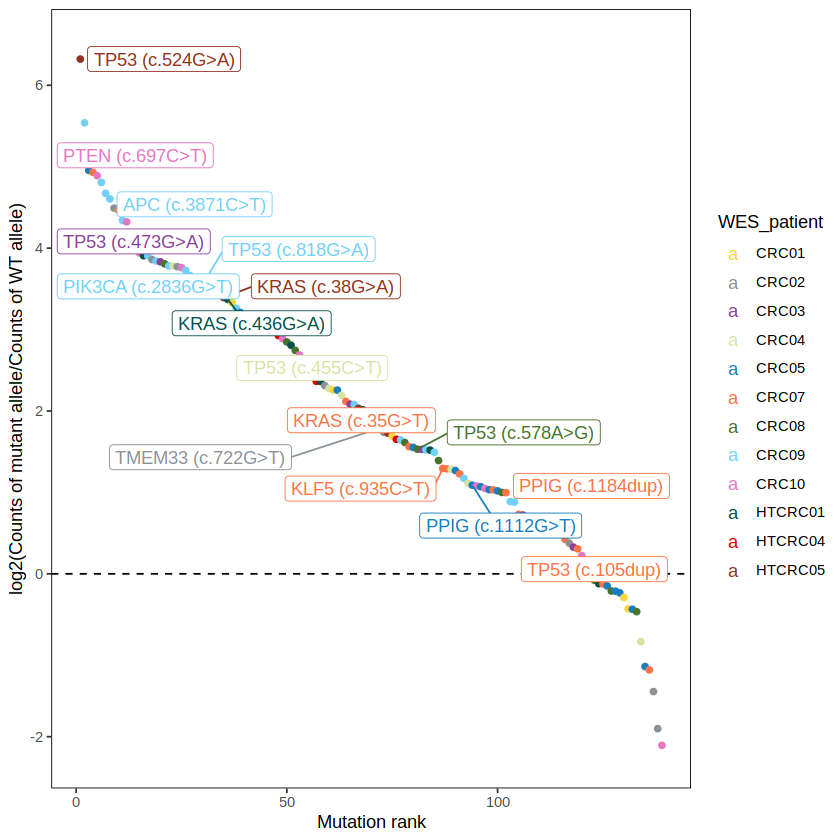

In [92]:
ggplot(test, aes(x = order, y = log2(ratio), color = WES_patient)) +
  geom_point() +
  mytheme + # scale_y_log10()+
  geom_hline(yintercept = 0, linetype = "dashed") +
  scale_color_manual(values = patient_color) +
  scale_y_continuous(limits = c(-2.2, 6.5), breaks = seq(-2, 6, by = 2)) +
  geom_label_repel(data = test %>% filter(
    order %in% test[which(test$GeneName %in% c("APC", "TP53", "KRAS", "KLF5", "PPIG", "PTEN", "PIK3CA", "TMEM33")), ]$order
  ), aes(
    label =
      gsub("", "", paste0(GeneName, " (", HGVSc, ")"))
  )) +
  labs(y = "log2(Counts of mutant allele/Counts of WT allele)", x = "Mutation rank")
ggsave(file = "03_0_CRC_RNA_SNV_corresponding_patient_point_mutation_rank_HGVSc.pdf", height = 5, width = 5)

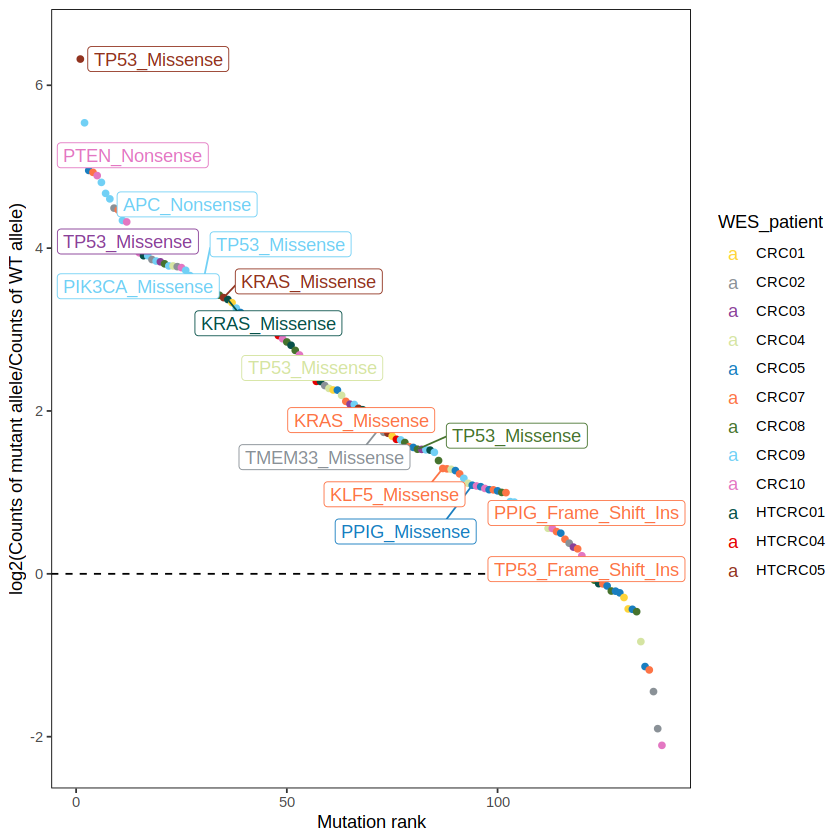

In [93]:
ggplot(test, aes(x = order, y = log2(ratio), color = WES_patient)) +
  geom_point() +
  mytheme + # scale_y_log10()+
  geom_hline(yintercept = 0, linetype = "dashed") +
  scale_color_manual(values = patient_color) +
  scale_y_continuous(limits = c(-2.2, 6.5), breaks = seq(-2, 6, by = 2)) +
  geom_label_repel(data = test %>% filter(
    order %in% test[which(test$GeneName %in% c("APC", "TP53", "KRAS", "KLF5", "PPIG", "PTEN", "PIK3CA", "TMEM33")), ]$order
  ), aes(
    label =
      gsub("_Mutation", "", paste0(GeneName, "_", Variant_Classification))
  )) +
  labs(y = "log2(Counts of mutant allele/Counts of WT allele)", x = "Mutation rank")
ggsave(file = "03_0_CRC_RNA_SNV_corresponding_patient_point_mutation_rank.pdf", height = 5, width = 5)

In [94]:
write.table(test, file = "03_0_CRC_RNA_SNV_corresponding_patient_point_mutation_rank.txt", quote = F, sep = "\t", row.names = F)

## Assess allelic expression imbalance

In [95]:
snv <- read.table(file = "03_0_CRC_RNA_SNV_corresponding_patient.txt", header = T, sep = "\t", check.names = F)

In [96]:
snv_alt <- read.table(file = "03_1_CRC_RNA_SNV_corresponding_patient_alt.txt", header = T, sep = "\t", check.names = F)

In [97]:
pdf("03_0_CRC_RNA_SNV_corresponding_patient_barplot.pdf", height = 4.5, width = 5)
hist(snv$alt_ratio, col = "#7a0e70")
dev.off()

png 
  2

In [98]:
pdf("03_1_CRC_RNA_SNV_corresponding_patient_barplot.pdf", height = 4.5, width = 5)
hist(snv_alt$alt_ratio, col = "#7a0e70")
dev.off()

png 
  2

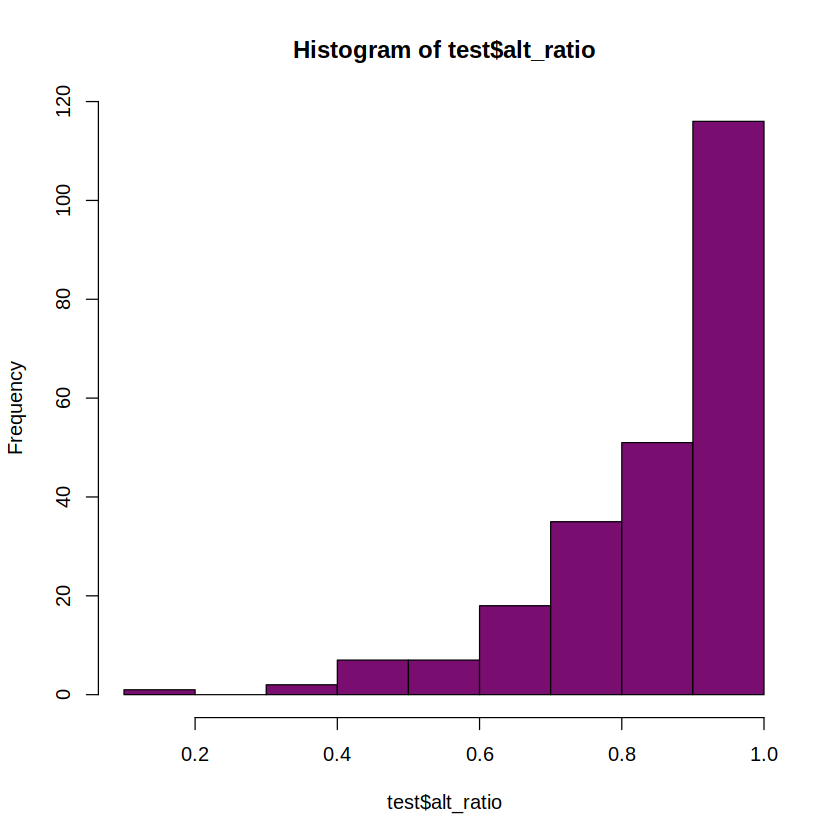

In [99]:
test <- snv_alt %>%
  group_by(gene_chr_pos) %>%
  summarise(
    mean_p = exp(mean(log(aei_binom.fdr))), alt_ratio = round(mean(alt_count / (alt_count + ref_count)), 2),
    total_c = mean(total_count)
  ) %>%
  arrange(mean_p)
hist(test$alt_ratio, col = "#7a0e70")

## Statistical association between AEI and HVG expression levels

In [100]:
p_color <- c(
  rev(
    c("#fff7f3", "#fde0dd", "#fcc5c0", "#fa9fb5", "#f768a1", "#dd3497", "#ae017e", "#7a0177", "#49006a")
  ),
  "#f5f5f5",
  c("#f7fcf5", "#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476", "#41ab5d", "#238b45", "#006d2c", "#00441b")
)

In [101]:
raw_count <- read.csv(file = "../CRC_HTCRC_01_RNA_QC/00_gene_counts_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)
depth <- colSums(raw_count)
tpm <- read.csv(file = "../CRC_HTCRC_01_RNA_QC/00_gene_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)

In [102]:
# Custom function to compute p-values using cor.test()
compute_p_values <- function(x, y) {
  p_values <- matrix(NA, ncol = ncol(y), nrow = ncol(x))
  for (i in 1:ncol(x)) {
    for (j in 1:ncol(y)) {
      test_result <- cor.test(x[, i], y[, j], use = "pairwise.complete.obs", method = "pearson")
      p_values[i, j] <- test_result$p.value
    }
  }
  rownames(p_values) <- colnames(x)
  colnames(p_values) <- colnames(y)
  return(p_values)
}

### CRC07

In [137]:
snv <- read.table(file = "03_0_CRC_RNA_SNV_corresponding_patient.txt", sep = "\t", check.names = F, header = T)
dim(snv)

[1] 14885    41

In [138]:
mypatient <- "CRC07"
snv_p <- snv %>% filter(ref_count + alt_count >= 3, patient %in% mypatient)
cells_p <- unique(snv_p$CellName)
length(cells_p)

ont_p <- subset(ont, cells = cells_p)
DefaultAssay(ont_p) <- "GENE"
table(ont_p@meta.data$celltype1)
ont_p <- NormalizeData(ont_p, normalization.method = "LogNormalize", scale.factor = 100000)
ont_p <- FindVariableFeatures(ont_p, selection.method = "vst", nfeatures = 1500)
hvg <- VariableFeatures(ont_p)
hvg <- log1p(tpm[hvg, cells_p])

[1] 236


Normal epithelium      Cancer cells 
               50               186 

#### allelic count matrix

In [ ]:
# build allelic count matrix
# total
total <- dcast(snv_p, gene_chr_pos ~ CellName, value.var = "total_count") %>%
  magrittr::set_rownames(.$gene_chr_pos) %>%
  dplyr::select(-gene_chr_pos) %>%
  replace(is.na(.), 0)
dim(total)
total <- log1p(t(total[, cells_p]) * 1e6 / depth[cells_p])

cor_total <- cor(
  total,
  t(hvg),
  use = "pairwise.complete.obs", method = "pearson"
) # pearson

cor_pvalue_total <- compute_p_values(total, t(hvg))

# alt
alt <- dcast(snv_p, gene_chr_pos ~ CellName, value.var = "alt_count") %>%
  magrittr::set_rownames(.$gene_chr_pos) %>%
  dplyr::select(-gene_chr_pos) %>%
  replace(is.na(.), 0)
dim(alt)
alt <- log1p(t(alt[, cells_p]) * 1e6 / depth[cells_p])

cor_alt <- cor(
  alt,
  t(hvg),
  use = "pairwise.complete.obs", method = "pearson"
)

cor_pvalue_alt <- compute_p_values(alt, t(hvg))

# ref
ref <- dcast(snv_p, gene_chr_pos ~ CellName, value.var = "ref_count") %>%
  magrittr::set_rownames(.$gene_chr_pos) %>%
  dplyr::select(-gene_chr_pos) %>%
  replace(is.na(.), 0)
dim(ref)
ref <- log1p(t(ref[, cells_p]) * 1e6 / depth[cells_p])

cor_ref <- cor(
  ref,
  t(hvg),
  use = "pairwise.complete.obs", method = "pearson"
)

cor_pvalue_ref <- compute_p_values(ref, t(hvg))

#### corralation difference

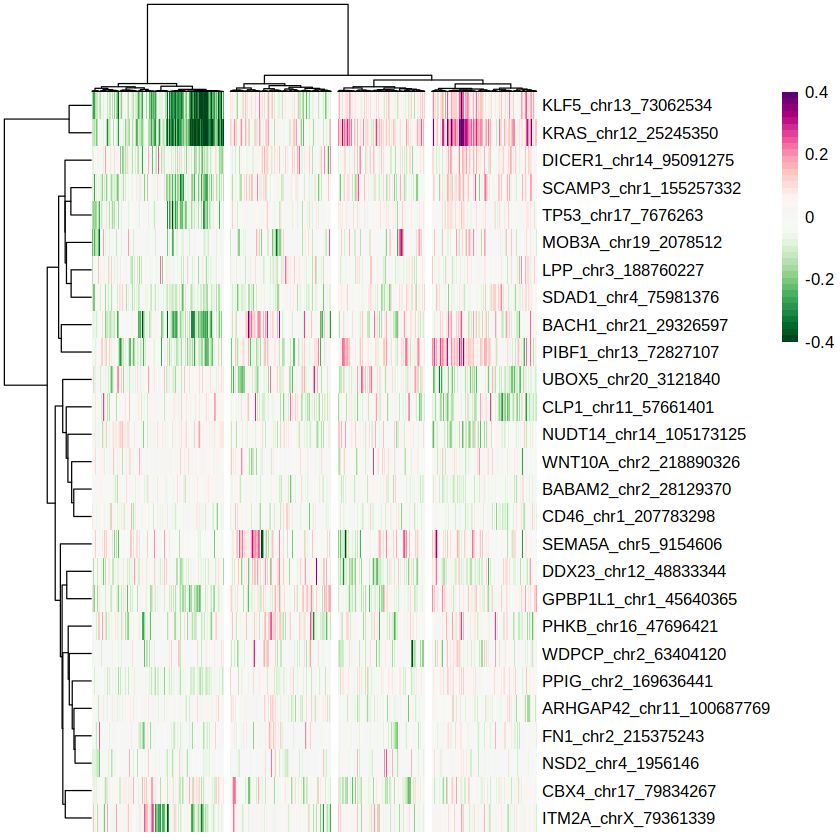

In [565]:
# 先查看alt与ref差异,找出区分最大的突变位点，此图中是KLF5和KRAS
cor_alt_minus_ref <- (cor_alt - cor_ref) %>%
  replace(is.na(.), 0) %>%
  as.data.frame() %>%
  filter(abs(rowSums(.)) > 0.01)
# cor_alt_minus_ref
rg <- 0.4
p_alt_minus_ref <- pheatmap(
  cor_alt_minus_ref,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(rev(p_color))(40),
  clustering_method = "ward.D", cutree_cols = 4, breaks = seq(-rg, rg, length.out = 40),
  clustering_distance_cols = "correlation"
  # cluster_rows = p_total$tree_row, cluster_cols = p_total$tree_col
)

In [566]:
ann_cluster <- cutree(p_alt_minus_ref$tree_col, k = 4) %>%
  as.data.frame() %>%
  magrittr::set_colnames(c("cluster")) %>%
  mutate_at(c("cluster"), as.factor)
write.csv(ann_cluster, file = sprintf("03_4_%s_1_cor_alt_minus_ref_cluster.csv", mypatient), quote = F)
ann_cluster_color <- list()
ann_cluster_color[["cluster"]] <- brewer.pal(n = 4, name = "Set3")
names(ann_cluster_color[["cluster"]]) <- names(table(ann_cluster$cluster))

p_alt_minus_ref <- pheatmap(
  cor_alt_minus_ref,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(rev(p_color))(40),
  clustering_method = "ward.D", cutree_cols = 4, breaks = seq(-rg, rg, length.out = 40),
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  clustering_distance_cols = "correlation",
  filename = sprintf("03_4_%s_1_cor_alt_minus_ref.pdf", mypatient), width = 8, height = 6
)

In [567]:
# plot
rg <- 0.4
# total
tmp <- cor_total[rownames(cor_alt_minus_ref), ] %>% replace(is.na(.), 0)
p_total <- pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(rev(p_color))(40), breaks = seq(-rg, rg, length.out = 40),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col,
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_2_total_cor.pdf", mypatient), width = 8, height = 6
)
tmp <- cor_pvalue_total[rownames(cor_alt_minus_ref), ]
tmp[tmp >= 0.05] <- 1
tmp[tmp < 0.05] <- 0
pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(c("#810f7c", "#f0f0f0"))(2),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col,
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_2_total_cor_pvalue.pdf", mypatient), width = 8, height = 6
)
# alt
tmp <- cor_alt[rownames(cor_alt_minus_ref), ] %>% replace(is.na(.), 0)
p_alt <- pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(rev(p_color))(40),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col, breaks = seq(-rg, rg, length.out = 40),
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_3_alt_cor.pdf", mypatient), width = 8, height = 6
)
tmp <- cor_pvalue_alt[rownames(cor_alt_minus_ref), ]
tmp[tmp >= 0.05] <- 1
tmp[tmp < 0.05] <- 0
pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(c("#810f7c", "#f0f0f0"))(2),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col,
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_3_alt_cor_pvalue.pdf", mypatient), width = 8, height = 6
)
# ref
tmp <- cor_ref[rownames(cor_alt_minus_ref), ] %>% replace(is.na(.), 0)
p_ref <- pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(rev(p_color))(40),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col, breaks = seq(-rg, rg, length.out = 40),
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_4_ref_cor.pdf", mypatient), width = 8, height = 6
)

tmp <- cor_pvalue_ref[rownames(cor_alt_minus_ref), ]
tmp[tmp >= 0.05] <- 1
tmp[tmp < 0.05] <- 0
pheatmap(
  tmp,
  scale = "none", show_colnames = F, border_color = "NA", color = colorRampPalette(c("#810f7c", "#f0f0f0"))(2),
  cluster_rows = p_alt_minus_ref$tree_row, cluster_cols = p_alt_minus_ref$tree_col,
  annotation_col = ann_cluster, annotation_colors = ann_cluster_color,
  filename = sprintf("03_4_%s_4_ref_cor_pvalue.pdf", mypatient), width = 8, height = 6
)

#### splicing factor: PPIG

In [146]:
snv <- read.table(file = "03_0_CRC_RNA_SNV_corresponding_patient.txt", sep = "\t", check.names = F, header = T)

In [147]:
(wes@data %>% filter(Hugo_Symbol %in% "PPIG"))[, 1:25]

Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,⋯,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,⋯,<fct>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
PPIG,0,.,GRCh38,chr2,169636186,169636186,+,Missense_Mutation,SNP,⋯,WES_CRC05_PT1,WES_CRC05_NT,G,G,NA,NA,NA,NA,NA,NA
PPIG,0,.,GRCh38,chr2,169636186,169636186,+,Missense_Mutation,SNP,⋯,WES_CRC05_PT2,WES_CRC05_NT,G,G,NA,NA,NA,NA,NA,NA
PPIG,0,.,GRCh38,chr2,169636441,169636442,+,Frame_Shift_Ins,INS,⋯,WES_CRC07_PT1,WES_CRC07_NT,-,-,NA,NA,NA,NA,NA,NA
PPIG,0,.,GRCh38,chr2,169636441,169636442,+,Frame_Shift_Ins,INS,⋯,WES_CRC07_PT2,WES_CRC07_NT,-,-,NA,NA,NA,NA,NA,NA


In [307]:
ont <- readRDS(file = "../CRC_HTCRC_02_RNA_seurat/CRC_HTCRC_01_RNA_5400_3262_tx/00_tx_5400_3262_hvg1869_PC1_20.rds")
DefaultAssay(ont) <- "GENE"

[1] 60

[1] 216


        Normal epithelium         WT (Cancer cells)   PPIG Mut (Cancer cells) 
                       60                        39                        33 
No covered (Cancer cells) 
                      144 

Centering and scaling data matrix

PC_ 1 
Positive:  DPEP1, S100A4, SLC2A1, KLK6, CLIC3, GPX3, TM4SF1, TFF2, LY6G6C, IFI6 
	   C6orf15, KRT6B, ANXA6, PTGES, IL23A, ADIRF, NTHL1, SCD, TNFRSF6B, LEMD1 
	   FSTL3, SPON2, PRSS33, RNF39, WNT11, KRT7, TUBA1A, CXCL8, KLK8, CXCL14 
Negative:  PIGR, NXPE4, NUPR1, PLA2G2A, AGR3, ST6GALNAC1, HMGCS2, MT1E, PLAC8, MT1G 
	   RNASE1, SELENOP, MUC2, SPINK1, ITLN1, C15orf48, FABP2, CHST5, MT2A, ADH1C 
	   OLFM4, ZG16, HOXB13, MT1M, CD74, ADTRP, LXN, LDHB, CA2, MT1F 
PC_ 2 
Positive:  TPSG1, B3GNT6, ZG16, ATOH1, MUC2, ITLN1, REP15, CMAHP, LRRC26, KLK1 
	   FAM177B, CD177, SPINK4, LYPD8, ST6GALNAC1, REG4, ITM2A, TMEM61, MT1H, WFDC2 
	   PRUNE2, HEPACAM2, GPX7, DNAJC12, SELENOM, DHRS9, CLDN8, GUCA2B, OTOP2, AQP8 
Negative:  CDC20, TK1, CCNB2, CCNA2, CCNB1, BIRC5, PTTG1, CENPK, CDKN3, ADH1C 
	   MAD2L1, AURKB, TROAP, ZWINT, AKR1B10, CENPH, GAL, LEFTY1, CXCL3, OLFM4 
	   HMGB2, RNASEH2A, PI3, REG1B, NCOA7, TYMS, CTSC, GLIPR2, CXCL2, PLLP 
PC_ 3 
Positive:  

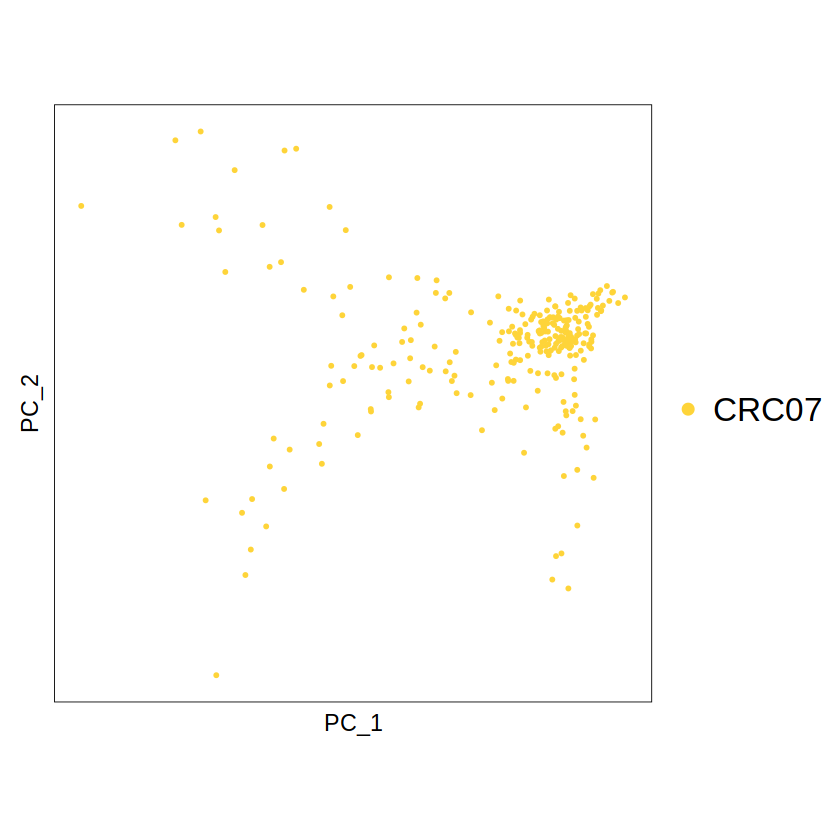

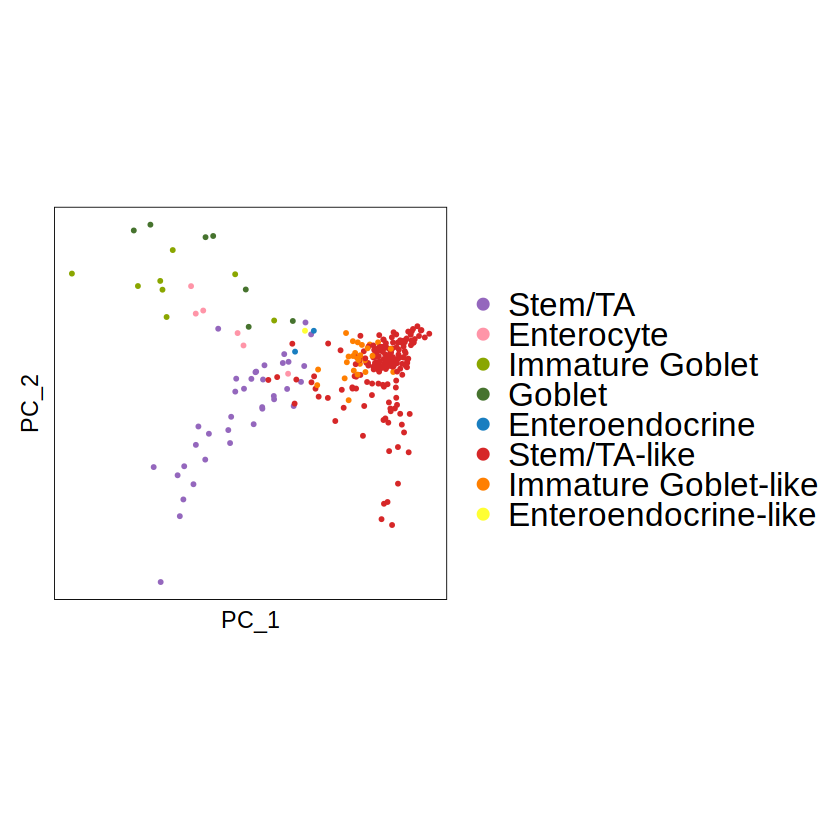

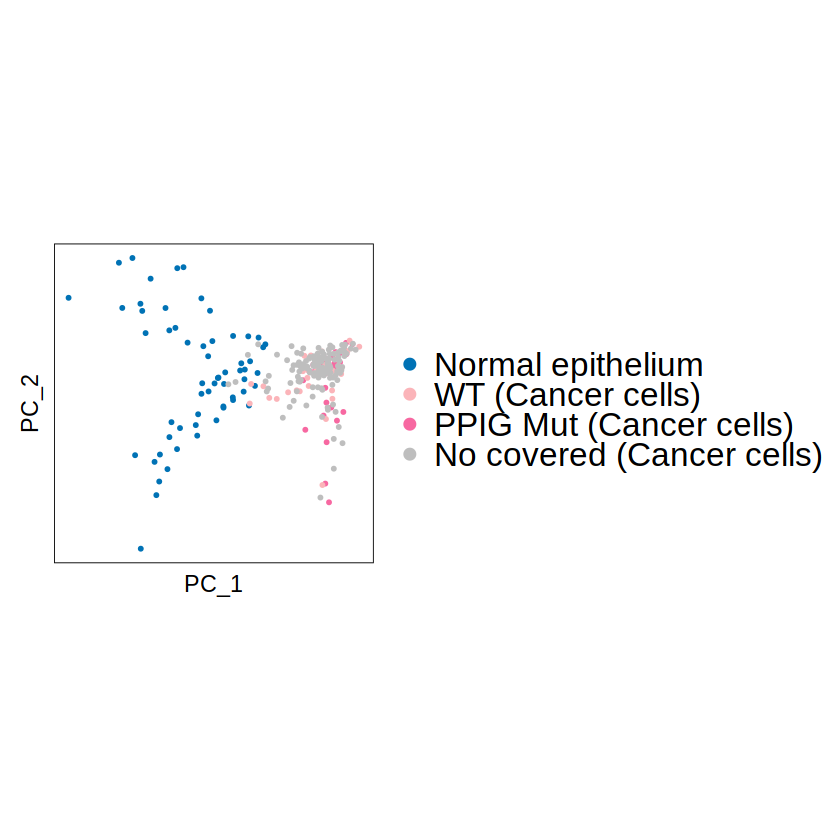

In [309]:
mypatient <- "CRC07"
ne_cells <- (meta %>% filter(celltype1 %in% "Normal epithelium", patient %in% mypatient))$CellName
length(ne_cells)
cc_cells <- (meta %>% filter(celltype1 %in% "Cancer cells", patient %in% mypatient))$CellName
length(cc_cells)

snv_p_ppig <- snv %>% filter(gene_chr_pos %in% "PPIG_chr2_169636441", patient %in% mypatient, CellName %in% cc_cells)
snv_p_ppig$PPIG <- "mut"
snv_p_ppig[which(snv_p_ppig$alt_binom.fdr > 0.05), ]$PPIG <- "wt"
cc_mut <- snv_p_ppig[which(snv_p_ppig$PPIG %in% "mut"), ]$CellName
cc_wt <- snv_p_ppig[which(snv_p_ppig$PPIG %in% "wt"), ]$CellName
cc_no_cover <- unique(setdiff(cc_cells, snv_p_ppig$CellName))

mysub <- subset(ont, cells = c(ne_cells, cc_mut, cc_wt, cc_no_cover))
mysub@meta.data$celltype4 <- as.character(mysub@meta.data$celltype1)
mysub@meta.data[mysub@meta.data$CellName %in% cc_wt, ]$celltype4 <- "WT (Cancer cells)"
mysub@meta.data[mysub@meta.data$CellName %in% cc_mut, ]$celltype4 <- "PPIG Mut (Cancer cells)"
mysub@meta.data[mysub@meta.data$CellName %in% cc_no_cover, ]$celltype4 <- "No covered (Cancer cells)"

mysub@meta.data$celltype4 <- factor(mysub@meta.data$celltype4, levels = c(
  "Normal epithelium", "WT (Cancer cells)", "PPIG Mut (Cancer cells)", "No covered (Cancer cells)"
))
Idents(mysub) <- mysub@meta.data$celltype4
table(mysub@meta.data$celltype4)

mysub <- NormalizeData(mysub, normalization.method = "LogNormalize", scale.factor = 100000)
mysub <- FindVariableFeatures(mysub, selection.method = "vst", nfeatures = 300)
mysub <- ScaleData(mysub, features = rownames(mysub)) # ,vars.to.regress = c("nUMI")
mysub <- RunPCA(mysub, features = VariableFeatures(object = mysub), npcs = 20)
saveRDS(mysub, file = sprintf("03_4_%s_6_PPIG.rds", mypatient))

DimPlot(mysub, reduction = "pca", dims = c(1, 2), group.by = "patient") +
  scale_color_manual(values = patient_color) + dimplot_theme
# ggsave(sprintf('03_4_%s_6_PPIG_pca_patient.pdf', mypatient), height = 3.5, width = 10)
DimPlot(mysub, reduction = "pca", dims = c(1, 2), group.by = "celltype3") +
  scale_color_manual(values = celltype3_color) + dimplot_theme
# ggsave(sprintf('03_4_%s_6_PPIG_pca_celltype3.pdf', mypatient), height = 3.5, width = 10)
DimPlot(mysub, reduction = "pca", dims = c(1, 2), group.by = "celltype4") +
  scale_color_manual(values = c(celltype1_color[1], "#fbb4b9", "#f768a1", "gray")) + dimplot_theme
# ggsave(sprintf('03_4_%s_6_PPIG_pca_mut.pdf', mypatient), height = 3.5, width = 10)

In [310]:
mut_deg <- FindMarkers(mysub, `ident.1` = c("PPIG Mut (Cancer cells)"), `ident.2` = c("WT (Cancer cells)")) # %>% filter(p_val < 0.05, abs(avg_log2FC) > 1)
mut_deg <- mut_deg %>%
  filter(p_val < 0.05, abs(avg_log2FC) > log2(2)) %>%
  arrange(-avg_log2FC)
mut_deg$group <- "Up"
mut_deg[which(mut_deg$avg_log2FC < 0), ]$group <- "Down"
mut_deg$SYMBOL <- rownames(mut_deg)
table(mut_deg$group)
write.csv(mut_deg, file = "03_4_CRC07_6_PPIG_deg.csv", quote = F)


Down   Up 
  40   49 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


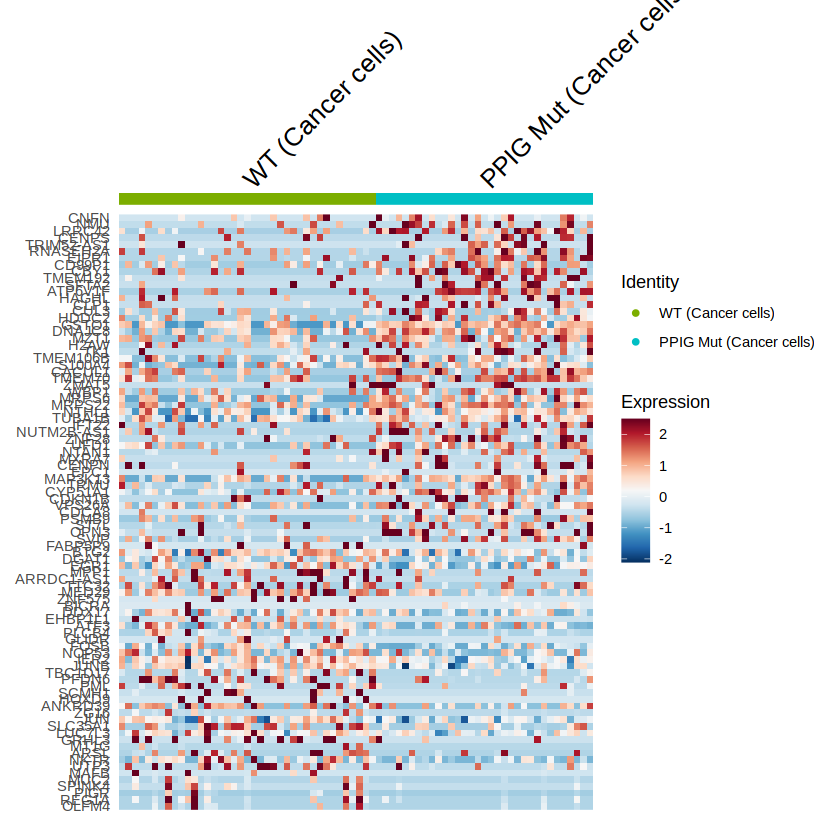

In [312]:
DoHeatmap(mysub,
  features = mut_deg$SYMBOL,
  cells = (mysub@meta.data %>% filter(celltype4 %in% c("PPIG Mut (Cancer cells)", "WT (Cancer cells)")))$CellName, draw.lines = F,
  group.by = "celltype4"
) + scale_fill_gradientn(colors = rev(colorRampPalette(RColorBrewer::brewer.pal(11, "RdBu"))(256))) #+ scale_fill_viridis()
ggsave(file = "03_4_CRC07_6_PPIG_deg_heatmap.pdf", height = 4, width = 6)